#### Student Name:
#### Student ID:


# Assignment 0
### From Midi to Audio and Back, Transcription from Audio 


Instructions:

This notebook is an interactive assignment; please read and follow the instructions in each cell.

Assignments are to be completed individually.

Cells that require your input (in the form of code or written response) will have 'Question #' above.

After completing the assignment, please submit this notebook as a PDF and your Mozart Dice Game MIDI.

Make sure to mark the page with your solution for each problem on Gradescope. Any problems without the correct pages marked may receive a score of 0.

Midi to pianoroll
--------

In [1]:
from __future__ import division
import sys
import argparse
import numpy as np
import pretty_midi
import librosa

Record using a simple midi software a short sequence of musical notes (midi keystrokes).

Have at least 6 different notes, organized into two or more voices with few simultaneous overlapping notes or simple chords.

See Pretty-Midi documentation http://craffel.github.io/pretty-midi/

(128, 200)


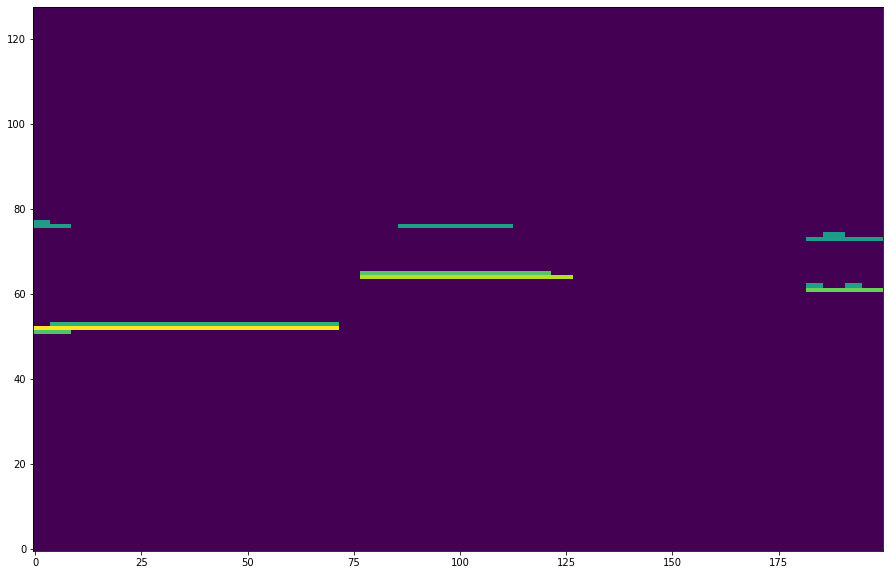

In [15]:
# Replace the sample.mid in the next line with your midi file name.

f = "sample.mid"
midi_data = pretty_midi.PrettyMIDI(f)
fs = 200 #midi sampling frequency
piano_matrix = midi_data.get_piano_roll(fs=200)

import numpy as np
print(np.shape(piano_matrix))
%matplotlib inline
import matplotlib.pyplot as plt
plt.figure(figsize = (20,10))
plt.imshow(piano_matrix[:,:1000], origin="lower")

##### Question 1 [10 points]
Write down the note names, play times and durations from the midi file you recorded, and match them to note coordinates in the plot. 
Explain how the plot and the notes are related.

You can use a program such as MuseScore to print the midi file in music notation. Note that there might be some difference in the typesetting, such as note shifting and duration quantization. 

``Your response here``

Audio Analysis with CQT
----

Using your midi software to record an audio file (synthesize the audio) from the midi file. Save it as "sample.wav"

In [6]:
# Replace sample.wav with your sound file
y, sr = librosa.load("sample.wav")

import matplotlib.pyplot as plt
%matplotlib inline

#plt.plot(y)

In [7]:
import IPython.display as ipd
ipd.Audio(data=y, rate=sr)

In [11]:
min_midi = 24 # Minimum MIDI note to transcribe
max_midi = 107 # Maximum MIDI note to transcribe
threshold = 64 # Threshold to activate note on event, 0-127

cqt = librosa.cqt(y, sr=sr, fmin=min_midi, n_bins=max_midi - min_midi)

##### Question 2 [20 Points]
Plot the image of CQT analysis next to the piano roll. Explain how the axis in CQT and the axes in piano roll are related

See Librosa CQT documentation https://librosa.org/doc/0.9.2/generated/librosa.cqt.html?highlight=cqt#librosa.cqt

In [3]:
### your code and plot here

``your explanation here``

Transcription experiment
---------

In [3]:
def cqt_to_piano_roll(cqt, min_midi, max_midi, threshold):
    '''Convert a CQT spectrogram into a piano roll representation by
     thresholding scaled magnitudes.

    Parameters
    ----------
    cqt : np.ndarray, shape=(max_midi-min_midi,frames), dtype=complex64
        CQT spectrogram of audio.
    min_midi : int
        Minimum MIDI note to transcribe.
    max_midi : int
        Maximum MIDI note to transcribe.
    threshold : int
        Threshold value to activate note on event, 0-127

    Returns
    -------
    piano_roll : np.ndarray, shape=(128,frames), dtype=int
        Piano roll representation on audio.

    '''
    piano_roll = np.abs(cqt)
    piano_roll = np.digitize(piano_roll,
                             np.linspace(piano_roll.min(),
                                         piano_roll.max(),
                                         127))
    piano_roll[piano_roll < threshold] = 0
    piano_roll = np.pad(piano_roll,
                        [(128 - max_midi, min_midi), (0, 0)],
                        'constant')
    return piano_roll


In [2]:
def piano_roll_to_pretty_midi(piano_roll, fs=100, program=0):
    '''Convert a Piano Roll array into a PrettyMidi object
     with a single instrument.

    Parameters
    ----------
    piano_roll : np.ndarray, shape=(128,frames), dtype=int
        Piano roll of one instrument
    fs : int
        Sampling frequency of the columns, i.e. each column is spaced apart
        by ``1./fs`` seconds.
    program : int
        The program number of the instrument.

    Returns
    -------
    midi_object : pretty_midi.PrettyMIDI
        A pretty_midi.PrettyMIDI class instance describing
        the piano roll.

    '''
    notes, frames = piano_roll.shape
    pm = pretty_midi.PrettyMIDI()
    instrument = pretty_midi.Instrument(program=program)

    # pad 1 column of zeros so we can acknowledge inital and ending events
    piano_roll = np.pad(piano_roll, [(0, 0), (1, 1)], 'constant')

    # use changes in velocities to find note on / note off events
    velocity_changes = np.nonzero(np.diff(piano_roll).T)

    # keep track on velocities and note on times
    prev_velocities = np.zeros(notes, dtype=int)
    note_on_time = np.zeros(notes)

    for time, note in zip(*velocity_changes):
        # use time + 1 because of padding above
        velocity = piano_roll[note, time + 1]
        time = time / fs
        if velocity > 0:
            if prev_velocities[note] == 0:
                note_on_time[note] = time
                prev_velocities[note] = velocity
        else:
            pm_note = pretty_midi.Note(
                velocity=prev_velocities[note],
                pitch=note,
                start=note_on_time[note],
                end=time)
            instrument.notes.append(pm_note)
            prev_velocities[note] = 0
    pm.instruments.append(instrument)
    return pm


##### Question 3 [40 points]

Call the appropriate function to translate cqt to piano roll

Set a threshold 0-127 on the CQT to extract the notes. You are free to suggest your own heuristics on how to set the threshold or cut out the notes from the audio analysis


In [4]:
### your code here

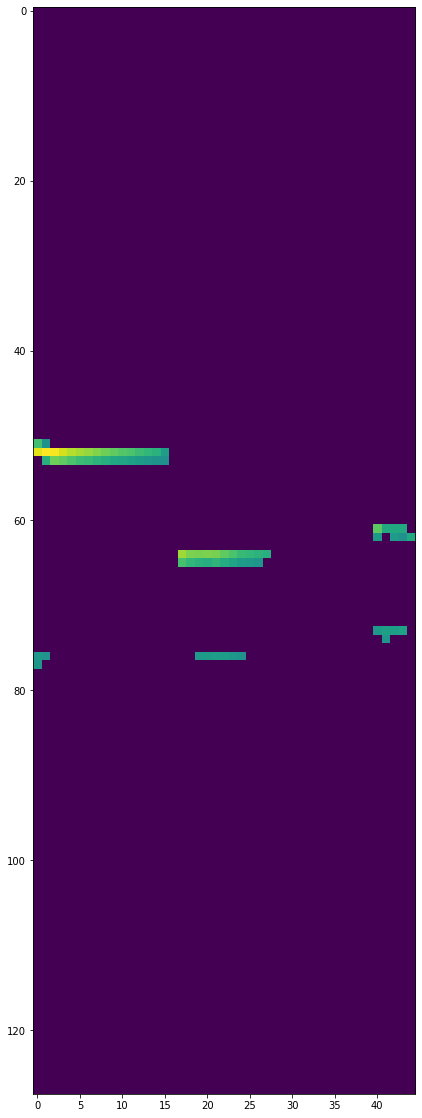

In [13]:
plt.figure(figsize=(10,20))
plt.imshow(pr)

##### Question 4 [20 points]

Generate midi from piano roll. In order to do so, determine the sampling frequency of the columns paremeter in the appropriate function call.

Hint: use the number of samples and the sampling rate of the audio file to determine its duration. Then match the pianoroll size to matches the required duration.

In [17]:
### your code here

# fs = 
pm = piano_roll_to_pretty_midi(pr, fs=fs,program=0)
pm.write("samplewav_to_midi.mid")

Download the midi result "samplewav_to_mid.mid" and open it in a midi editor, such as MuseScore

Open sample.mid in midi editor and play sample.wav on your computer
##### Questions 5 [10 points]:
Discuss the following aspects of your assignment:
1. Why did we use CQT?
2. How sample.mid amd samplewav_to_mid.mid compare?
3. What needs to be done to improve the result?



```your response here```